In [1]:
from ms_autoencoder import GraphEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn, optim
import torch
import numpy as np
from tqdm import tqdm
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import networkx as nx
import os 
import pickle
import seaborn as sns

#Make reproducible results
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

#For saving results(Change this for local version)
data_dir = os.path.join(os.getcwd(), 'community-detetction-deep-learning', 'Data')


#For plotting
name = "Accent_r"
cmap = get_cmap(name) 
colors = cmap.colors  

sns.set_theme()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
file_path = os.path.join(data_dir, 'toy_dataset.pkl')
with open(file_path, 'rb') as f:
    g = pickle.load(f)
    
#initialize single position for all visualizations    
pos = nx.spring_layout(g, seed=SEED)

### Preprocessing the graph to put it into the Autoencoder

In [3]:
#Preprocessing
X = np.asarray(nx.to_numpy_matrix(g))
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster} 
Y = np.array(list(partition_true.values()))
k = len(np.unique(Y))

#Wine dataset: Original Implementation
'''
from sklearn.datasets import load_wine
from sklearn import preprocessing

data = load_wine()
X = data.data
Y = data.target
k = len(np.unique(Y))

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
'''

S = cosine_similarity(X, X)


#Should this be X.sum or S.sum ? From Github Implementation
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D.dot(S).dot(D)).float().to(device)

#My Reading of the Paper
'''
D = np.diag(X.sum(axis=1))
X_train = np.linalg.inv(D) @ S
X_train = torch.tensor(X_train).float().to(device)
'''



'\nD = np.diag(X.sum(axis=1))\nX_train = np.linalg.inv(D) @ S\nX_train = torch.tensor(X_train).float().to(device)\n'

### Training the Autoencoder

In [4]:
epochs = 500
beta = 0   #Unregularized works best. Maybe the KL divergence implementation is flawed
rho = 0.5 #paper had 0.01
lr = 1e-4

#First cycle
layers = [len(X_train)] + [512, 256, 512] + [len(X_train)]
model = GraphEncoder(layers, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#Train first cycle
with tqdm(total=epochs) as tq:
  for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    X_hat = model(X_train)
    loss = model.loss(X_hat, X_train, beta, rho)
    nmi = normalized_mutual_info_score(model.get_cluster(random_state=SEED), Y, average_method='arithmetic')
    loss.backward()
    optimizer.step()
    tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
    tq.update()

embedding = model.outputs['lin2']


#Second to 4th Cycle
for j in range(4):
  X_train = embedding.detach()
  layers = [X_train.shape[1]] + [X_train.shape[1], int(X_train.shape[1] * 0.8), X_train.shape[1]] + [X_train.shape[1]]
  model = GraphEncoder(layers, k).to(device)
  
  optimizer = optim.Adam(model.parameters(), lr=lr)

  #Train
  with tqdm(total=epochs) as tq:
    for epoch in range(1, epochs + 1):
      optimizer.zero_grad()
      X_hat = model(X_train)
      loss = model.loss(X_hat, X_train, beta, rho)
      nmi = normalized_mutual_info_score(model.get_cluster(random_state=SEED), Y, average_method='arithmetic')
      loss.backward()
      optimizer.step()
      tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
      tq.update()

  embedding = model.outputs['lin2']

 70%|██████▉   | 348/500 [00:13<00:05, 29.22it/s, loss=6.516, nmi=0.086]/content/ms_autoencoder.py:61: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=self.clusters, init='k-means++', random_state=random_state).fit(self.outputs['lin2'].detach().cpu().numpy())
 82%|████████▏ | 410/500 [00:15<00:04, 20.37it/s, loss=6.464, nmi=0.045]/content/ms_autoencoder.py:61: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=self.clusters, init='k-means++', random_state=random_state).fit(self.outputs['lin2'].detach().cpu().numpy())
 86%|████████▋ | 432/500 [00:16<00:02, 24.70it/s, loss=6.451, nmi=0.053]/content/ms_autoencoder.py:61: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=self.clu

### Performance Evaluation

In [15]:
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster} 
partition_predicted = model.get_cluster(random_state=SEED)
partition_predicted = {node: comm for node, comm in zip(list(partition_true.keys()), partition_predicted)}

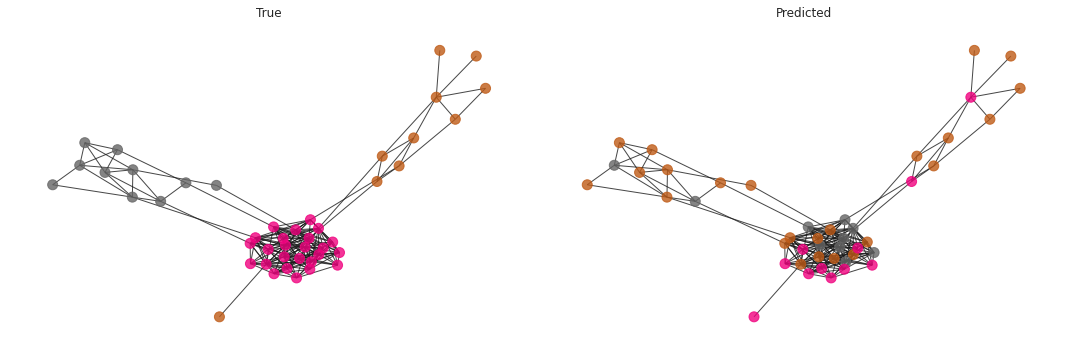

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
nx.draw(g,
        pos,
        node_size=100,
        alpha=0.8,
        node_color=[colors[community] for node, community in partition_true.items()],
        with_labels=False,
        ax=axes[0]
       )
axes[0].set_title('True')

nx.draw(g,
        pos,
        node_size=100,
        alpha=0.8,
        node_color=[colors[community] for node, community in partition_predicted.items()],
        with_labels=False,
        ax=axes[1]
       )
axes[1].set_title('Predicted')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import normalized_mutual_info_score


normalized_mutual_info_score(list(partition_true.values()), 
                             list(partition_predicted.values()))

0.1567553399279871